In [1]:
from torch import nn
import torch

In [2]:
from torch.nn.utils.rnn import pad_sequence

In [3]:
import numpy as np

In [4]:
import pandas as pd

In [5]:
import os

In [6]:
from einops import rearrange

In [7]:
import random

In [8]:
from torch.utils.data import DataLoader

In [9]:
import torchvision.transforms as T

In [10]:
from skimage.util import random_noise

In [11]:
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_theme()

In [12]:
import torchaudio

C:\Users\aag12\anaconda3\envs\ml_env\lib\site-packages\torchaudio\backend\utils.py:62: UserWarning: No audio backend is available.
  warnings.warn("No audio backend is available.")


In [13]:
from sklearn import preprocessing

In [14]:
from sklearn.model_selection import train_test_split

# Defining Dataseat

In [15]:
from datasets import load_dataset

In [16]:
from datasets import disable_caching
disable_caching()

In [17]:
with open("goodfiles.txt", 'r') as f:
    all_files = f.readlines()
all_files = [g.strip().replace("npy", 'mp3') for g in all_files if len(g.strip()) > 0]

In [18]:
all_files[:3]

['01/846501.mp3', '34/1288334.mp3', '98/1082098.mp3']

In [19]:
good_files, test_files = train_test_split(all_files, test_size=0.2)

In [20]:
len(good_files), len(test_files)

(2200, 551)

In [21]:
def files_to_labels(files):
    col_names = ['TRACK_ID',
     'ARTIST_ID',
     'ALBUM_ID',
     'PATH',
     'DURATION',
     'TAGS',
     'TAGS2',
     'TAGS3',
     'TAGS4',
     'TAGS5',
     'TAGS6',
     'TAGS7',
     'TAGS8',
     'TAGS9']
    MOODPATH = "../../../Downloads/autotagging_moodtheme.tsv.txt"
    df = pd.read_csv(MOODPATH, sep='\t', names=col_names)
    df = df[df["PATH"].isin(files)]
    inds = {'fast': 0,
     'sexy': 1,
     'mellow': 2,
     'heavy': 3,
     'horror': 4,
     'travel': 5,
     'holiday': 6,
     'groovy': 7,
     'funny': 8,
     'retro': 9,
     'hopeful': 10,
     'powerful': 11,
     'cool': 12,
     'nature': 13,
     'game': 14}

    final_labels = []
    for i in range(len(df)):
        curr = np.zeros(len(inds))
        moods = list(df.iloc[i])[5:]
        for theme in moods:
            if type(theme) == str and "mood" in theme:
                check = theme.split("---")[-1]
                if check in inds:
                    curr[inds[check]] = 1
            else:
                pass

        final_labels.append(curr)
    return final_labels

In [22]:
train_labels = files_to_labels(good_files)

In [23]:
test_labels = files_to_labels(test_files)

In [24]:
train_labels[:2]

[array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0.]),
 array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0.])]

In [25]:
# train_np_files = [("../../subset_moodtheme/" + g).replace(".mp3", ".npy") for g in good_files]
# test_np_files = [("../../subset_moodtheme/" + g).replace(".mp3", ".npy") for g in test_files]
train_np_files = ["../../mtg-jamendo-dataset/all_data/" + g.replace("mp3", "npy") for g in good_files]
test_np_files = ["../../mtg-jamendo-dataset/all_data/" + g.replace("mp3", "npy") for g in test_files]

In [26]:
train_np_files[:2], test_np_files[:2]

(['../../mtg-jamendo-dataset/all_data/98/824298.npy',
  '../../mtg-jamendo-dataset/all_data/65/1121465.npy'],
 ['../../mtg-jamendo-dataset/all_data/78/916878.npy',
  '../../mtg-jamendo-dataset/all_data/07/1293707.npy'])

In [27]:
import time

In [28]:
# SEQ_LEN = 10000
SEQ_LEN = 3000
# SEQ_LEN = 5000

# Dataset

In [29]:
from torchvision import transforms

In [30]:
class MusicDataset(torch.utils.data.Dataset):   
    def __init__(self, np_file_paths, labels, transforms, seq_len=10000, random_start=True, upsample_factor=10):
        self.seq_len = seq_len
        self.files = np_file_paths
        self.labels = labels
        self.transforms = transforms
        self.random_start = random_start
        self.upsample_factor = upsample_factor
        
    def __len__(self):
        return len(self.files) * self.upsample_factor

    def __getitem__(self, index):
        effective_index = index % len(self.files)
        fname = self.files[effective_index]
        x = np.load(fname)
        x = torch.from_numpy(x).float()
        if self.random_start and x.shape[-1] > self.seq_len:
            # longer than seqlen, select random subset
            start = random.randint(0, x.shape[-1] - self.seq_len)
            x = x[:,start:start+self.seq_len]
        else:
            x = x[:,:self.seq_len]
        old_x = x.unsqueeze(0)
        # clamp between bounds and scale
        compressed_x = (torch.clamp(old_x, min=-90, max=30) + 90) / 120
        x = self.transforms(compressed_x)
        
        item = {"input": x, "label_ids":[effective_index], "labels": torch.tensor(self.labels[effective_index])}
#         item = {"input": x, "pixel_values":x}
        
        return item

In [31]:
class AddGaussianNoise(object):
    def __init__(self, mean=0., std=1.):
        self.std = std
        self.mean = mean
        
    def __call__(self, tensor):
        return tensor + torch.randn(tensor.size()) * self.std + self.mean
    
    def __repr__(self):
        return self.__class__.__name__ + '(mean={0}, std={1})'.format(self.mean, self.std)

In [32]:
img_size = 496
noise_composed = transforms.Compose([
   transforms.Resize((96, img_size)),
    transforms.Normalize((0.5542), (0.1604)),
    AddGaussianNoise(0., 0.04)
])
nonoise_composed = transforms.Compose([
   transforms.Resize((96, img_size)),
    transforms.Normalize((0.5542), (0.1604))
])

In [33]:
# pt_train_dataset = MusicDataset(train_np_files, train_labels, noise_composed, seq_len=SEQ_LEN, random_start=True, upsample_factor=5)
# pt_test_dataset = MusicDataset(test_np_files, test_labels, nonoise_composed, seq_len=SEQ_LEN, random_start=False, upsample_factor=1)
pt_train_dataset = MusicDataset(train_np_files, train_labels, noise_composed, seq_len=SEQ_LEN, random_start=True, upsample_factor=5)
pt_test_dataset = MusicDataset(test_np_files, test_labels, nonoise_composed, seq_len=SEQ_LEN, random_start=False, upsample_factor=1)

In [34]:
batch_size = 128
train_dl = DataLoader(
    pt_train_dataset,
    batch_size=batch_size,
    shuffle=True,
    num_workers=0,
    collate_fn=None,
    pin_memory=False,
 )

test_dl = DataLoader(
    pt_test_dataset,
    batch_size=1,
    shuffle=False,
    num_workers=0,
    collate_fn=None,
    pin_memory=False,
 )

## ViT For Small

In [35]:
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')

In [36]:
from vit_pytorch.vit_for_small_dataset import ViT

In [37]:
from tqdm import tqdm
import torch.optim as optim

In [38]:
# v = ViT(
#     image_size = 500,
# #     patch_size = 32,
#     patch_size = 16,
#     num_classes = 15,
# #     dim = 1024,
#     dim = 512,
#     depth = 6,
#     heads = 8,
# #     mlp_dim = 2048,
#     mlp_dim = 512,
#     channels=1
# )
# mae = MAE(
#     encoder = v,
#     masking_ratio = 0.75,   # the paper recommended 75% masked patches
#     decoder_dim = 512,      # paper showed good results with just 512
#     decoder_depth = 6       # anywhere from 1 to 8
# )

# v = ViT(
#     image_size = (96, 496),
#     patch_size = 16,
#     num_classes = 15,
#     dim = 1024,
#     depth = 6,
#     heads = 16,
#     mlp_dim = 2048,
#     dropout = 0.1,
#     emb_dropout = 0.1,
#     channels=1
# )

v = ViT(
    image_size = (96, 496),
    patch_size = 16,
    num_classes = 15,
    dim = 512,
    depth = 4,
    heads = 8,
    mlp_dim = 1024,
    dropout = 0.1,
    emb_dropout = 0.1,
    channels=1,
    pool="mean"
)

In [39]:
start = torch.rand(1, 1, 96, 496)

In [40]:
v

ViT(
  (to_patch_embedding): SPT(
    (to_patch_tokens): Sequential(
      (0): Rearrange('b c (h p1) (w p2) -> b (h w) (p1 p2 c)', p1=16, p2=16)
      (1): LayerNorm((1280,), eps=1e-05, elementwise_affine=True)
      (2): Linear(in_features=1280, out_features=512, bias=True)
    )
  )
  (dropout): Dropout(p=0.1, inplace=False)
  (transformer): Transformer(
    (layers): ModuleList(
      (0): ModuleList(
        (0): PreNorm(
          (norm): LayerNorm((512,), eps=1e-05, elementwise_affine=True)
          (fn): LSA(
            (attend): Softmax(dim=-1)
            (dropout): Dropout(p=0.1, inplace=False)
            (to_qkv): Linear(in_features=512, out_features=1536, bias=False)
            (to_out): Sequential(
              (0): Linear(in_features=512, out_features=512, bias=True)
              (1): Dropout(p=0.1, inplace=False)
            )
          )
        )
        (1): PreNorm(
          (norm): LayerNorm((512,), eps=1e-05, elementwise_affine=True)
          (fn): FeedFor

In [41]:
v(start).shape

torch.Size([1, 15])

In [47]:
def get_total_loss(model, dataloader):
    total_loss = 0
    num = 0
    for batch_idx, data in enumerate(dataloader):
        inputs, labels = data['input'].to(device), data['labels'].to(device)

        outputs = model(inputs)
        total_loss += criterion(outputs, labels.float())
        num += len(labels)
    return total_loss.item() / num

In [48]:
model = v.to(device)

In [49]:
pos_weight = 1 / (torch.sum(torch.tensor(test_labels), dim=0) / len(test_labels))

In [50]:
pos_weight

tensor([21.1923, 27.5500, 19.0000, 16.2059, 18.3667, 17.7742, 13.7750, 17.2188,
        15.7429, 11.9783, 13.4390, 12.8140,  9.8393,  9.5000, 10.2037],
       dtype=torch.float64)

In [51]:
# optimizer = optim.AdamW(mae.parameters(), lr=1e-2)
# optimizer = optim.AdamW(mae.parameters(), lr=5e-2, weight_decay=0.05, betas=(0.9, 0.95))
optimizer = optim.AdamW(model.parameters(), lr=1e-3, weight_decay=0.05, betas=(0.9, 0.95))
# criterion = nn.BCEWithLogitsLoss(pos_weight = pos_weight.to(device), reduction="mean")
criterion = nn.BCEWithLogitsLoss(reduction="mean")

In [52]:
train_losses = []
test_losses = []
model.train()
for epoch in range(10):
    total_loss = 0
    for batch_idx, data in tqdm(enumerate(train_dl), total=len(train_dl)):
        optimizer.zero_grad()
    
        inputs, labels = data['input'].to(device), data['labels'].to(device)
        outputs = model(inputs)
        
        loss = criterion(outputs, labels)

        loss.backward()
        optimizer.step()
        
        total_loss += loss.item()
        
    with torch.no_grad():
        test_loss = get_total_loss(model, test_dl)
        train_losses.append(total_loss)
        test_losses.append(test_loss)
        print(f"Epoch: {epoch}; Loss: {total_loss}; Test Loss: {test_loss}")
    if test_loss == min(test_losses):
        torch.save(v.state_dict(), f"./trained-vit-{epoch}.pt")

_ = model.eval()

100%|██████████████████████████████████████████████████████████████████████████████████████████| 86/86 [01:05<00:00,  1.32it/s]


Epoch: 0; Loss: 22.449757698266087; Test Loss: 0.2538582305077416


100%|██████████████████████████████████████████████████████████████████████████████████████████| 86/86 [01:03<00:00,  1.36it/s]


Epoch: 1; Loss: 21.983863780658453; Test Loss: 0.25349268419989224


100%|██████████████████████████████████████████████████████████████████████████████████████████| 86/86 [01:03<00:00,  1.36it/s]


Epoch: 2; Loss: 21.91532603368079; Test Loss: 0.25468716214659426


100%|██████████████████████████████████████████████████████████████████████████████████████████| 86/86 [01:03<00:00,  1.36it/s]


Epoch: 3; Loss: 21.92051545115861; Test Loss: 0.25422967540374036


100%|██████████████████████████████████████████████████████████████████████████████████████████| 86/86 [01:03<00:00,  1.36it/s]


Epoch: 4; Loss: 21.843631653887243; Test Loss: 0.25326715320511


100%|██████████████████████████████████████████████████████████████████████████████████████████| 86/86 [01:03<00:00,  1.36it/s]


Epoch: 5; Loss: 21.789261034364824; Test Loss: 0.2524037439031307


100%|██████████████████████████████████████████████████████████████████████████████████████████| 86/86 [01:03<00:00,  1.36it/s]


Epoch: 6; Loss: 21.785192612541458; Test Loss: 0.2543030615943313


100%|██████████████████████████████████████████████████████████████████████████████████████████| 86/86 [01:03<00:00,  1.35it/s]


Epoch: 7; Loss: 21.724007743594374; Test Loss: 0.2537487881586037


100%|██████████████████████████████████████████████████████████████████████████████████████████| 86/86 [01:03<00:00,  1.35it/s]


Epoch: 8; Loss: 21.652464203602833; Test Loss: 0.2526478845281307


100%|██████████████████████████████████████████████████████████████████████████████████████████| 86/86 [01:05<00:00,  1.31it/s]


Epoch: 9; Loss: 21.666591645337338; Test Loss: 0.2542340508822737


In [53]:
# # torch.save(v.state_dict(), f"./lastnotbest-trained-vit-{epoch}.pt")
# torch.save(mae.state_dict(), f"./maeklastnotbest-trained-vit-{epoch}.pt")

In [54]:
30 * 800 / 60 / 60

6.666666666666667

Text(0.5, 1.0, 'ViT Small v1: Train/Test Loss on Finetuning Task')

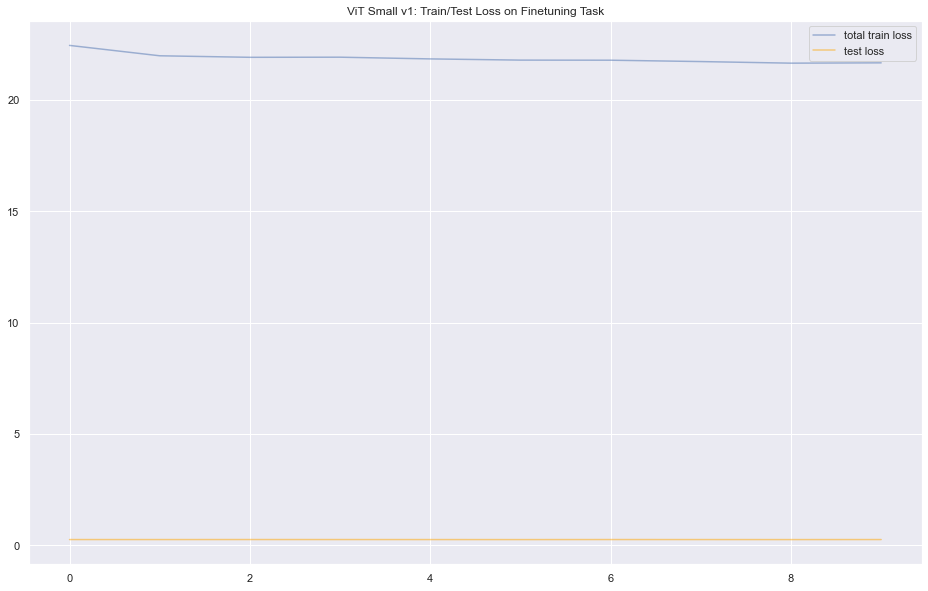

In [55]:
plt.figure(figsize=(16, 10))
ranger = list(range(len(train_losses)))
sns.lineplot(x=ranger, y=train_losses, label="total train loss", alpha=0.5)
# sns.lineplot(x=ranger, y=adjusted_train_losses, label="adjusted train loss")
# ax2 = plt.twinx()
# sns.lineplot(x=ranger, y=test_losses, label="test loss", ax=ax2, color="orange", alpha=0.5)
sns.lineplot(x=ranger, y=test_losses, label="test loss", color="orange", alpha=0.5)
plt.title("ViT Small v1: Train/Test Loss on Finetuning Task")
# plt.savefig("mae_v1.png")

In [ ]:
model.eval()

combined_preds = []
combined_labels = []

with torch.no_grad():
    total_correct = 0
    zero_correct = 0
    total_values = 0
    only_positives = [0, 0]
#     for batch_idx, data in enumerate(ft_test_dl):
#     for batch_idx, data in enumerate(train_dl):
    for batch_idx, data in enumerate(test_dl):
#     for batch_idx, data in enumerate(longft_test_dataset):
#     for batch_idx, data in enumerate(ft_train_eval_dl):
        inputs, labels = data['input'].to(device), data['labels'].to(device)

        outputs = model(inputs)
#         outputs = torch.concat([h(outputs) for h in heads], dim=1)
        outputs = torch.sigmoid(outputs)
        
        combined_preds.append(outputs)
        combined_labels.append(labels)
        
        outlabels = torch.zeros_like(outputs)
        outlabels[outputs >= 0.5] = 1
        outlabels[outputs < 0.5] = 0
        
        num_correct = torch.sum(outlabels == labels).item()
        num = len(labels) * 15
        
        total_correct += num_correct
        total_values += num
        zero_correct += torch.sum(labels == 0).item()
        
        only_positives[0] += torch.sum(labels).item()
        only_positives[1] += torch.sum(labels[labels == 1] == outlabels[labels == 1]).item()
        

print(total_correct / total_values)

print(f"{total_correct} out of {total_values}")

print("Performance on positive labels")

print(only_positives[1] / only_positives[0])

print(f"{only_positives[1]} out of {only_positives[0]}")

print("WHAT IF WE JUST PREDICTED ZERO")

print(zero_correct / total_values)

print(f"{zero_correct} out of {total_values}")

In [ ]:
all_preds = torch.cat(combined_preds)
all_labels = torch.cat(combined_labels)
all_preds.shape, all_labels.shape

In [ ]:
from sklearn import metrics

In [ ]:
aucs = []
for i in range(15):
    preds = all_preds[:,i].cpu()
    targs = all_labels[:,i].cpu()
#     fpr, tpr, thresholds = metrics.roc_curve(targs, preds, pos_label=1)
    fpr, tpr, thresholds = metrics.roc_curve(targs, preds, pos_label=1)
    auc = metrics.auc(fpr, tpr)
    aucs.append(auc)
    print(f"Head: {i}; AUC: {auc}")

In [ ]:
sum(aucs) / len(aucs)

In [ ]:
from sklearn.metrics import roc_auc_score

In [ ]:
roc_auc_score(targs, preds)

In [558]:
import scikitplot as skplt
import matplotlib.pyplot as plt

In [559]:
from vit_pytorch.learnable_memory_vit import ViT, Adapter

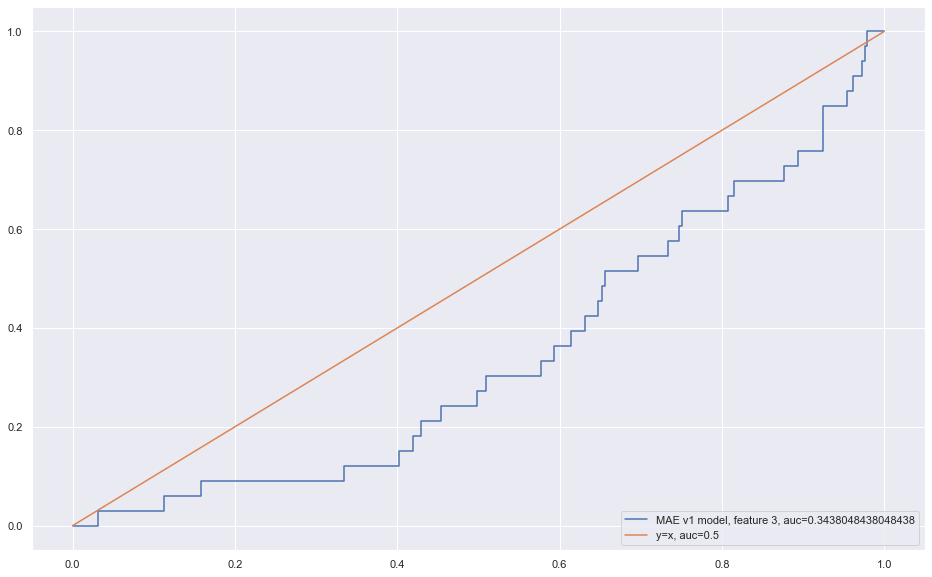

In [565]:
plt.figure(figsize=(16, 10))
preds = all_preds[:,3].cpu()
targs = all_labels[:,3].cpu()
fpr, tpr, _ = metrics.roc_curve(targs, preds)
auc = metrics.roc_auc_score(targs, preds)
plt.plot(fpr,tpr,label="MAE v1 model, feature 3, auc="+str(auc))

fpr, tpr, _ = metrics.roc_curve(targs, np.zeros_like(targs))
auc = metrics.roc_auc_score(targs, np.zeros_like(targs))
plt.plot(fpr,tpr,label="y=x, auc="+str(auc))

plt.legend(loc=4)
plt.show()